<a href="https://colab.research.google.com/github/moonlovist/ML_DLA/blob/main/DLA_1D_CNN_ting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Galaxy Morphology with CNNs

The goal of this tutorial is to illustrate a very basic supervised binary classification with CNNs. The goal is to setup a ML algorithm to determine the visual morphological type of nearby galaxies from the Sloan Digital Sky Survey. The first deep learning papers in Astronomy addressed this problem at low and high redshift (Dielemann+15, Huertas-Company+15).


We use a Convolutional Neural Network (deep learning) to learn the features directly from the images with no catalog information. The CNN  model is implemented here with Keras and a TensorFlow backend.  We use as training set, the visually classified sample of ~14,000 galaxies by Nair&Abraham. For illustration purposes, we use jpeg RGB images as input. However the same methodology can be applied to fits.

---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import os
from sklearn import preprocessing

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import  BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers import MaxPool2D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score,auc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Deep Learning (CNN)
This section illustrates how to use a Convolutional Neural Network to estimate the visual morphology. The input of the network are now the images themselves without parameters. The CNN then automatically extracts the features. This is the main difference between classical and deep learning.

### Data Download and Preparation

In [38]:
#Load data
pathinData="/content/drive/My Drive/ML_DLA"

#images
X = np.load(pathinData+'/Classification_catalog_SN_6_mock_4.7.01.npy')
X = X[:,0:2000,:,:]
X = np.squeeze(X,axis=3)
#morphological class
Y1 = np.load(pathinData+'/Classification_id_SN_6_mock_4.7.01.npy') 
Y2 = np.load(pathinData+'/Classification_z_SN_6_mock_4.7.01.npy') 
#Y = np.transpose(np.vstack((Y1,Y2)))
Y = Y1

In [35]:
X.shape

(10447, 2000, 1)

In [7]:
Y[Y==1].shape

(1679,)

In [39]:
#X = np.vstack((X[Y==0][0:27343,:,:,:],X[Y==1]))
#Y = np.hstack((Y[Y==0][0:27343],Y[Y==1]))
X = np.vstack((X[Y==0][0:1679,:,:],X[Y==1]))
Y = np.hstack((Y[Y==0][0:1679],Y[Y==1]))

In [52]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

In [53]:
Y

array([0., 1., 0., ..., 1., 1., 1.])

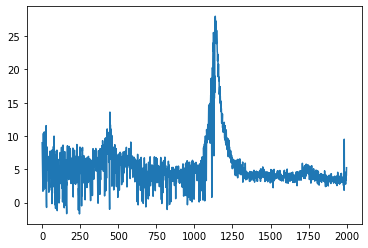

In [11]:
plt.plot(np.squeeze(np.squeeze(X[7],axis=2),axis=1))

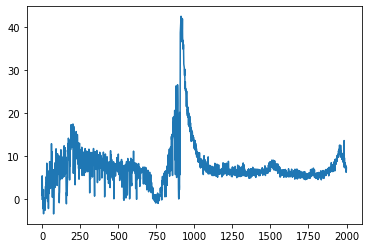

In [13]:
plt.plot(np.squeeze(np.squeeze(X[2000],axis=2),axis=1))

In [54]:
# Spliting in Training and Test datasets, 4/5 of galaxies for training, 1/5 for testing
x_train = X[0:len(X)//5*3,:,:]
x_val = X[len(X)//5*3:len(X)//5*4,:,:]   
x_test = X[len(X)//5*4:,:,:]
t_train = Y[0:len(Y)//5*3]
t_val = Y[len(Y)//5*3:len(Y)//5*4]
t_test = Y[len(Y)//5*4]
print ('Y_train.shape= ', t_train.shape)   

Y_train.shape=  (2013,)


### Pre-processing of images (Normalization)

In [42]:
mu = np.amax(x_train,axis=(1,2))
for i in range(0,mu.shape[0]):
    x_train[i,:,:] = x_train[i,:,:]/mu[i]
    
mu_test = np.amax(x_test,axis=(1,2))
for i in range(0,mu_test.shape[0]):
    x_test[i,:,:] = x_test[i,:,:]/mu_test[i]

mu_val = np.amax(x_val,axis=(1,2))
for i in range(0,mu_val.shape[0]):
    x_val[i,:,:] = x_val[i,:,:]/mu_val[i] 


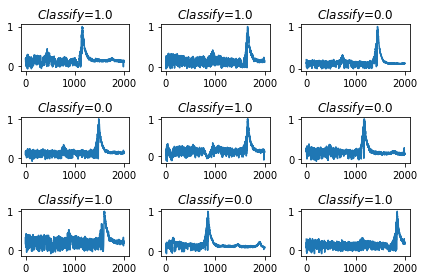

In [57]:
randomized_inds_train = np.random.permutation(len(x_train))

fig = plt.figure()


for i,j in zip(randomized_inds_train[0:9],range(9)):
  ax = fig.add_subplot(3, 3, j+1)
  im = ax.plot(x_train[i])
  plt.title('$Classify$='+str(t_train[i]))
  fig.tight_layout() 

### Model definition
The following cell defines the model architecture. There is a Convolutional part made of multiple convolutinal layers with differnet depths and filter sizes. MaxPooling are used to reduce the sizes of tensors as we go deeper into the network. Batch Normalization and Dropout are use at the training phase to reduce over fitting.

In [58]:
# CNN Ting
def CNN_Nair(img_channels, img_rows, img_cols):
    
    # some hyperparamters you can chage
    dropoutpar=0.5
    depth=16   
    nb_dense = 64
  
    inputs = layers.Input(shape=(2000, 1))
    conv1 = layers.Conv1D(16, (100), activation='relu', padding="same")(inputs)
    #pool1 = layers.MaxPooling2D((100, 1))(conv1)
    conv2 = layers.Conv1D(64, (100), activation='relu', padding="same")(conv1)
    pool2 = layers.MaxPooling1D((20))(conv2)
    conv3= layers.Conv1D(64, (100), activation='relu', padding="same")(pool2)
    pool3 = layers.MaxPooling1D((100))(conv3)
    flatten1 = layers.Flatten()(pool3) 
    dense1 = layers.Dense(64,activation='relu')(flatten1)
    dense2 = layers.Dense(32,activation='relu')(dense1)
    dense3 = layers.Dense(1,activation='softmax')(dense2)
    model = models.Model(inputs, dense3)

    #model=Sequential()
    #model.add(Conv2D(64, 64,1, activation='relu',padding='same',input_shape=(img_rows, img_cols, img_channels)))
    #model.add(Conv2D(64, 64,12, activation='relu',padding='same',input_shape=(img_rows, img_cols, img_channels)))
    #model.add(BatchNormalization())  ## batch normalization layer
    ## ADD LAYERS / CONVOLUTIONS HERE
    ## FROM HERE IS THE FULLY CONNECTED PART OF THE MODEL. YOU CAN ALSO CHANGE THIS
    #model.add(Flatten())
    #model.add(Dense(nb_dense, activation='relu'))
    #model.add(Dropout(dropoutpar)) 

    ## OUTPUT LAYER -- DO NOT CHANGE
    #model.add(Dense(3, kernel_initializer='uniform', activation='sigmoid'))  

    # COMPILES THE MODEL. WE USE CROSS-ENTROPY LOSS. YOU CAN CHANGE THE OPTIMIZER
    # IF NEEDED
    print("Compilation...")
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
    print("... done!")
    print("Model Summary")
    print("===================")
    model.summary()
    return model

This cell is to delete prevois runs if needed. Only run if you want to delete the results from previous runs.

In [59]:
RESET=True
if RESET:
  os.system("rm -r "+pathout)

Main code for training the CNN model defined previously. All outputs are stored in pathout. Change if you want to keep different models. BY default the dataset is augmented to reduce overfitting. You can turn it off be setting data_augmentation to False.

In [60]:
# train params - hardocded for simplicity - you can change them
pathout='model' #output folder to store the results
model_name = '/cnn1'  #name of the final model which is saved in pathout

LOAD_MODEL=False

batch_size = 100
nb_epoch = 20  #number of iterations for training - Can be changed
data_augmentation = False # if set to True the data will be augmented at every iteration


    
# input image dimensions
img_rows, img_cols = x_train.shape[1:3]
img_channels = 1

#Avoid more iterations once convergence
patience_par=10
#earlystopping = EarlyStopping(monitor='val_loss',patience = patience_par,verbose=0,mode='auto' )
modelcheckpoint = ModelCheckpoint(pathout+model_name+"_best.hd5",monitor='val_loss',verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir=pathout)

#build model
#cnn=CNN_Nair(img_channels, img_rows, img_cols)
cnn=CNN_Nair(img_channels, img_rows, img_cols)
if LOAD_MODEL:
  cnn.load_weights(pathout+model_name+'.hd5')


if not data_augmentation:
  print('Not using data augmentation.')
  history = cnn.fit(x_train, t_train,
                            batch_size=batch_size,
                            epochs=nb_epoch,
                            validation_data=(x_val, t_val),
                            shuffle=True)
                            #callbacks=[modelcheckpoint,tensorboard])#callbacks=[earlystopping, modelcheckpoint,tensorboard])
else:
  print('Using real-time data augmentation.')

  # this will do preprocessing and realtime data augmentation. FEEL FREE TO
  # CHANGE THE PARAMETERS AND SEE THE EFFECTS
  datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False, 
            featurewise_std_normalization=False, 
            samplewise_std_normalization=False,
            zca_whitening=False, 
            rotation_range=0,
            width_shift_range=0.1,  
            height_shift_range=0.1, 
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=False)  

        
  datagen.fit(x_train)
        
  history = cnn.fit_generator(
                    datagen.flow(x_train, t_train, batch_size=batch_size),
                    steps_per_epoch=batch_size,
                    epochs=nb_epoch,
                    validation_data=(x_val, t_val),
                    callbacks=[modelcheckpoint,tensorboard]#[ earlystopping, modelcheckpoint,tensorboard]
                )



print("Saving model...")
cnn.save_weights(pathout+model_name+".hd5",overwrite=True)
    
        


Compilation...
... done!
Model Summary
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 2000, 1)]         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2000, 16)          1616      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2000, 64)          102464    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 64)           409664    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_10 (Flatten

Text(0, 0.5, 'Loss')

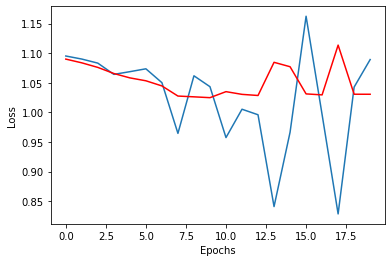

In [ ]:
plot(history.history['loss'])
plot(history.history['val_loss'],color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Predictions and comparisons of different approaches
The following cells use the trained models (RF,ANN and CNN) to predict the morphological class of the test dataset and compare the performance of the different algorithms. 

In [ ]:
print("Predicting...")
print("====================")
LOAD_MODEL=False
if LOAD_MODEL:
  cnn = tf.keras.models.load_model(pathout+model_name+".hd5")

Y_pred_DL = cnn.predict(x_test)


We now compute the global accuracy as well as ROC and P-R curves. If you are not familiar with these curves please see the lecture slides or click [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) 

In [ ]:
#global accuracy

## TRY DIFFERENT MODELS - SEE THE EFFECTS ON THE FINAL ROC CURVES


Y_pred_DL_class=Y_pred_DL*0
Y_pred_DL_class[Y_pred_DL>0.5]=1

print("Global Accuracy CNN:", accuracy_score(t_test, Y_pred_DL_class))




# ROC curve (False positive rate vs. True positive rate)
fpr_DL, tpr_DL, thresholds_DL = roc_curve(t_test, Y_pred_DL)

print("AUC CNN:", auc(fpr_DL, tpr_DL))

#plot ROC
fig = plt.figure() 
title('ROC curve',fontsize=18)
xlabel("FPR", fontsize=20)
ylabel("TPR", fontsize=20)
xlim(0,1)
ylim(0,1)
plot(fpr_DL,tpr_DL,linewidth=3,color='red',label='CNN')

legend(fontsize=14)


# Precision Recall curve (False positive rate vs. True positive rate)
precision_DL, recall_DL, thresholds_DL = precision_recall_curve(t_test, Y_pred_DL)

#plot PR curve
fig = plt.figure() 
title('P-R curve',fontsize=18)
xlabel("Precision", fontsize=20)
ylabel("Recall", fontsize=20)
xlim(0,1)
ylim(0,1)
plot(precision_DL,recall_DL,linewidth=3,color='red',label='CNN')
legend(fontsize=14)

Can you make a more complex architecture i.e. Resnet? Does it improve?

The follwing cells visualize some random examples of bad classifications in order to explore what the network has understood. If you run multiple times the examples will change.

### Bad classifications of CNNs

In [ ]:
# objects classifed as early-types by the CNN but visually classifed as late-types
bad = np.where((Y_pred_DL[:,0]<0.5)&(t_test==1))
randomized_inds_train = np.random.permutation(bad)

fig = plt.figure()
fig.suptitle("Galaxies visually classifed as Class1 but classified as Class0",fontsize=10)
for i,j in zip(randomized_inds_train[0][0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(x_test[i,:,:])
  plt.title('$Morph$='+str(t_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)



# objects classifed as late-types by the CNN but visually classifed as early-types
bad2 = np.where((Y_pred_DL[:,0]>0.5)&(t_test==0))
randomized_inds_train = np.random.permutation(bad2)

fig = plt.figure()
fig.suptitle("Galaxies visually classifed as Class0 but classified as Class1",fontsize=10)
for i,j in zip(randomized_inds_train[0][0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(x_test[i,:,:])
  plt.title('$Morph$='+str(t_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)


Can you plot the mass-color plane of the previous notebook (ANN Galaxy Morphology) and see where bad CNN classifications are located ?

In [ ]:
## THIS IS THE MAIN CELL TO DEFINE A CONVOLUTIONAL MODEL
## FELL FREE TO EDIT / CHANGE / ADD LAYERS
## AS IT IS NOW IT CONTAINS ONLY ONE COVOLUTIONAL LAYER

def CNN_Nair(img_channels, img_rows, img_cols):
    
    # some hyperparamters you can chage
    dropoutpar=0.5
    depth=16   
    nb_dense = 64
  
    #inputs = layers.Input(shape=(64, 64, 1))
    #conv1A = layers.Conv2D(16, (7, 7), activation='relu', padding="same",strides=(1,1))(inputs)
    #model = models.Model(inputs, conv1A)

    model=Sequential()
    model.add(Conv2D(64, 64,1, activation='relu',padding='same',input_shape=(img_rows, img_cols, img_channels)))
    model.add(Conv2D(64, 64,12, activation='relu',padding='same',input_shape=(img_rows, img_cols, img_channels)))
   
    model.add(BatchNormalization())  ## batch normalization layer

    ## ADD LAYERS / CONVOLUTIONS HERE
    
    ## FROM HERE IS THE FULLY CONNECTED PART OF THE MODEL. YOU CAN ALSO CHANGE THIS
    model.add(Flatten())
    model.add(Dense(nb_dense, activation='relu'))
    model.add(Dropout(dropoutpar)) 

    ## OUTPUT LAYER -- DO NOT CHANGE
    model.add(Dense(3, kernel_initializer='uniform', activation='sigmoid'))  

    # COMPILES THE MODEL. WE USE CROSS-ENTROPY LOSS. YOU CAN CHANGE THE OPTIMIZER
    # IF NEEDED
    print("Compilation...")
    #model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
    print("... done!")
    print("Model Summary")
    print("===================")
    model.summary()
    return model